# Analyse Geschäfte

In [1]:
from pathlib import Path
import pandas as pd
import datetime
import utils
import json
import numpy as np
#pd.options.plotting.backend = "plotly"

In [2]:
csv_path = Path('../export/csv_for_infographics')

## Load Data

In [4]:
df_raw = pd.read_csv(Path('../export/geschaefte.csv'))

# Only Members
df_raw = df_raw[df_raw.erstunterzeichneristkantonsrat == True]

# To Datetime
df_raw['start'] = pd.to_datetime(df_raw['start'])

# Calculate Amtsjahr (Amtsjahr 2020 = 1.5.2020 - 30.4.2021)
df_raw['year'] = df_raw['start'].dt.year
df_raw['month'] = df_raw['start'].dt.month
df_raw['session'] = df_raw.apply(lambda row: row['year'] if row['month'] > 5 else row['year'] - 1, axis=1)

# Concat Name for convenience reasons
df_raw['_name'] = df_raw.apply(lambda row: "%s %s" % (row['erstunterzeichnervorname'], row['erstunterzeichnername']), axis = 1)

# Load Kantonsrats-member-history
with open(Path('../export/mitglieder.json'), encoding='utf-8') as f:
    kantonsrat = json.load(f)

# Typecast
utils.kantonsrat_to_datetime(kantonsrat)

## Vorstösse pro Jahr

<AxesSubplot:title={'center':'Anzahl Anträge pro Amtsjahr'}, xlabel='session'>

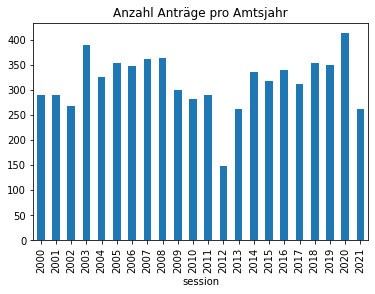

In [5]:
df_raw.groupby('session').agg({'_name': 'count'}).plot.bar(legend=False, title='Anzahl Anträge pro Amtsjahr')

## Wer reicht pro Jahr am meisten ein?

<AxesSubplot:title={'center':'Top Geschäfte-Einreicher'}, xlabel='session'>

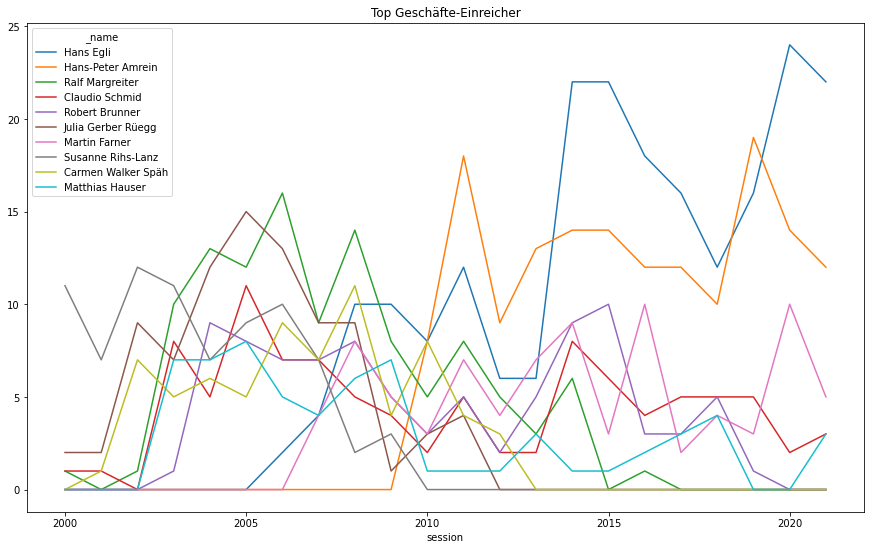

In [6]:
df = df_raw[df_raw.erstunterzeichneristkantonsrat == True]

df = pd.pivot_table(df, index=['_name'], columns='session', values='start', aggfunc='count').fillna(0)

df['s'] = df.sum(axis=1)

df = df.sort_values('s', ascending=False).head(10)
df.drop(columns='s', inplace=True)

df.T.plot.line(figsize=(15, 9), title='Top Geschäfte-Einreicher')

## Wer hat am wenigsten in der laufenden Legislatur eingereicht
Be aware: Every Kantonsrat since 5.5.2019 - some may have quit since then  
**Info: Hans-Jacob Heitz	ist ein Fehler, Daten falsch erfasst**

In [7]:
# Select only since legislatur
dt_start = datetime.datetime(2019, 5, 5)
df = df_raw[(df_raw.start >= dt_start) & (df_raw.erstunterzeichneristkantonsrat == True)]
df = df.groupby('_name').agg({'krnr': 'count'}).reset_index()

# Reorder Kantonsrat Einsitz. Oldest first
for rat in kantonsrat:
    rat['einsitz'] = sorted(rat['einsitz'], key = lambda x: x['end'])
    rat['partei'] = sorted(rat['partei'], key = lambda x: x['start'])

# Select Kantonsräte
members = list(filter(lambda x: len(list(filter(lambda y: y['end'] > dt_start, x['einsitz']))) > 0, kantonsrat))

# Create DataFrame from records
df_members = list(map(lambda x: {
    '_name': "%s %s" % (x['vorname'], x['name']),
    'partei': x['partei'][-1]['bezeichnung'],
    'einsitz_start': x['einsitz'][-1]['start'],
    'einsitz_end': x['einsitz'][-1]['end']
    }, members))
df_members = pd.DataFrame(df_members)

# Merge with votes
df_members = df.merge(df_members, on = '_name', how='left')
df_members.rename(columns={'krnr': 'count'}, inplace=True)

df_members = df_members.set_index('_name')
df_members = df_members.sort_values('count')

df_members[df_members['count'] <= 1]


,count,partei,einsitz_start,einsitz_end
_name,,,,
Alexander Jäger,1,FDP,2015-05-18,2100-12-31
Céline Widmer,1,SP,2012-05-07,2019-12-01
Daniel Hodel,1,GLP,2011-01-24,2021-03-22
Daniela Güller,1,GLP,2020-07-06,2100-12-31
Elisabeth Pflugshaupt,1,SVP,2015-05-18,2100-12-31
Esther Guyer,1,Grüne,1998-08-17,2100-12-31
Gregor Kreuzer,1,GLP,2021-03-29,2100-12-31
Hans-Jacob Heitz,1,NaN,NaT,NaT
Isabel Bartal,1,SP,2014-01-27,2100-12-31


<AxesSubplot:xlabel='partei'>

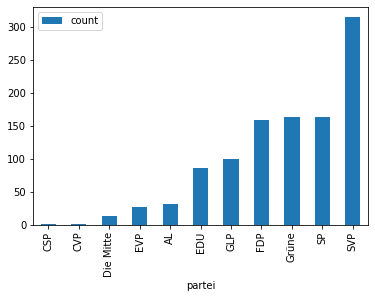

In [8]:
# By Party
df_members.groupby('partei').agg({'count': 'sum'}).sort_values('count').plot.bar()

## Men vs Women, plain numbers

<AxesSubplot:title={'center':'Vorstösse Frauen/Männer'}, xlabel='session'>

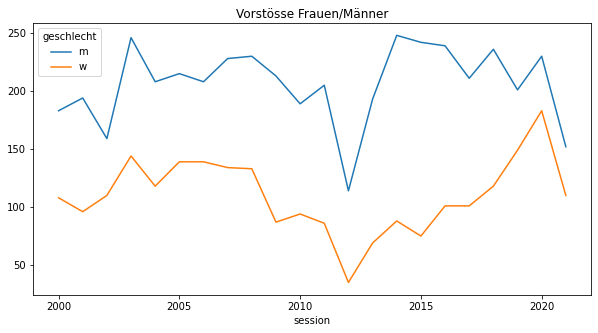

In [9]:
pd.pivot_table(df_raw, index='session', columns='geschlecht', values='_name', aggfunc='count').plot(title='Vorstösse Frauen/Männer', figsize=(10, 5))

In [10]:
pd.pivot_table(df_raw, index='session', columns='geschlecht', values='_name', aggfunc='count')

geschlecht,m,w
session,,
2000,183,108
2001,194,96
2002,159,110
2003,246,144
2004,208,118
2005,215,139
2006,208,139
2007,228,134
2008,230,133


## Men vs Women per capita

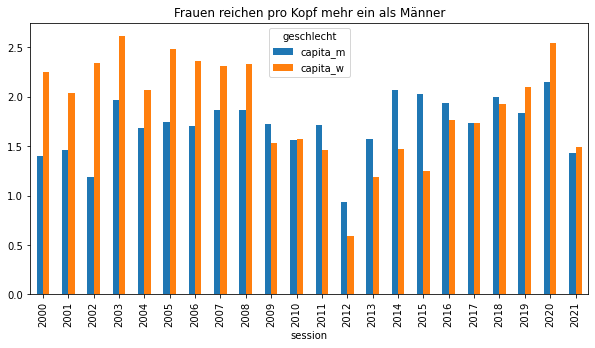

In [11]:
# Calculate, how many m and w where in Kantonsrat at that time. Reference day: 1. 7. 20XX
dtx = []
for year in range(df_raw['session'].min(), df_raw['session'].max() + 1):

    dt = datetime.datetime(year, 7, 1)
    df = utils.kantonsrat_as_dataframe(kantonsrat, dt)
    df['year'] = year
    dtx.append(df)

df = pd.concat(dtx)

# Pivot by year
df = pd.pivot_table(df, index='year', columns='geschlecht', values='name', aggfunc='count')
df.rename(columns={'m': 'count_m', 'w': 'count_w'}, inplace=True)

df_pivot = pd.pivot_table(df_raw[df_raw.erstunterzeichneristkantonsrat == True], index='session', columns='geschlecht', values='_name', aggfunc='count')

# Join both DFs
df_pivot = df_pivot.join(df)

# Calc per Capita
df_pivot['capita_m'] = round(df_pivot['m'] / df_pivot['count_m'], 2)
df_pivot['capita_w'] = round(df_pivot['w'] / df_pivot['count_w'], 2)

df_pivot[['capita_m', 'capita_w']].plot.bar(figsize=(10, 5), title='Frauen reichen pro Kopf mehr ein als Männer')
df_pivot.to_csv(csv_path / 'geschaefte_per_capita.csv')

In [12]:
df_pivot

geschlecht,m,w,count_m,count_w,capita_m,capita_w
session,,,,,,
2000,183,108,131,48,1.40,2.25
2001,194,96,133,47,1.46,2.04
2002,159,110,134,47,1.19,2.34
2003,246,144,125,55,1.97,2.62
2004,208,118,124,57,1.68,2.07
2005,215,139,123,56,1.75,2.48
2006,208,139,122,59,1.70,2.36
2007,228,134,122,58,1.87,2.31
2008,230,133,123,57,1.87,2.33


## a) Wessen Vorstösse werden am meisten abgelehnt?

In [13]:
# Lets calculate only "Ablehnung" and get absolute numbers as well

# Only Erledigt
df = df_raw[(df_raw.status == 'Erledigt') & (df_raw.erstunterzeichneristkantonsrat == True)]

# Only from this type
geschaefte = ['Postulat', 'Motion', 'Dringliches Postulat', 'Einzelinitiative', 'Parlamentarische Initiative']
df = df[df.geschaeftsart.isin(geschaefte)]

# pivot
df = pd.pivot_table(df, index=['_name', 'geschlecht'], columns='letzterschritttyp', values='krnr', aggfunc='count').fillna(0)

# Combine Ablehnung + Ablehnung - Nicht vorläufig unterstützt
df['Ablehnung'] = df['Ablehnung'] + df['Ablehnung - Nicht vorläufig unterstützt']
df.drop(columns='Ablehnung - Nicht vorläufig unterstützt', inplace=True)

# sum
df['sum'] = df.sum(axis=1)
df = df[['Ablehnung', 'sum']]
# Percentage
df['%'] = round(df['Ablehnung'] * 100 / df['sum'], 1)

# Remove less than 5
df = df[df['sum'] >= 5]

df = df.sort_values('%', ascending=False)

df.head(15)

,letzterschritttyp,Ablehnung,sum,%
_name,geschlecht,,,
Mattea Meyer,w,5.0,5.0,100.0
Jürg Stünzi,m,4.0,5.0,80.0
Maria Rita Marty,w,4.0,5.0,80.0
Sabine Wettstein-Studer,w,4.0,5.0,80.0
Chantal Galladé,w,4.0,5.0,80.0
Daniel Häuptli,m,4.0,5.0,80.0
Esther Hildebrand,w,9.0,12.0,75.0
Rosmarie Joss,w,5.0,7.0,71.4
Monika Wicki,w,8.0,12.0,66.7


## b) The same for Gender

<AxesSubplot:title={'center':'Anträge von Frauen werden öfters abgelehnt'}, xlabel='geschlecht'>

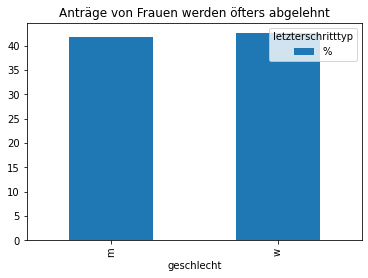

In [14]:
df_b = df.copy().reset_index()

df_b = df_b.groupby('geschlecht').agg({'Ablehnung': 'sum', 'sum': 'sum', '_name': 'count'})

df_b['%'] = round(df_b['Ablehnung'] * 100 / df_b['sum'], 1)

df_b[['%']].plot.bar(title='Anträge von Frauen werden öfters abgelehnt')


In [15]:
df_b.head()

letzterschritttyp,Ablehnung,sum,_name,%
geschlecht,,,,
m,373.0,893.0,83,41.8
w,236.0,554.0,49,42.6


## c) The same per year

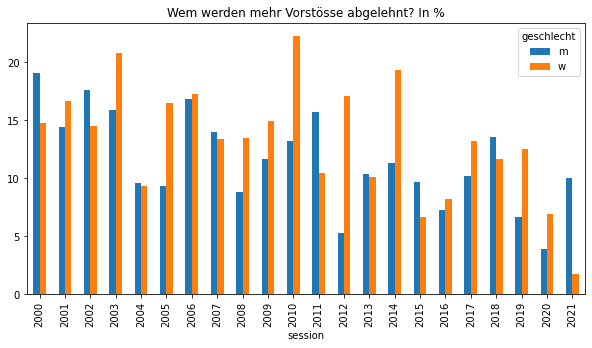

In [16]:
# Only Erledigt
df = df_raw[(df_raw.status == 'Erledigt') & (df_raw.erstunterzeichneristkantonsrat == True)]

# pivot
df = pd.pivot_table(df, index=['session', 'geschlecht'], columns='letzterschritttyp', values='krnr', aggfunc='count').fillna(0)

# Combine Ablehnung + Ablehnung - Nicht vorläufig unterstützt
df['Ablehnung'] = df['Ablehnung'] + df['Ablehnung - Nicht vorläufig unterstützt']
df.drop(columns='Ablehnung - Nicht vorläufig unterstützt', inplace=True)

# sum
df['sum'] = df.sum(axis=1)

df = df[['Ablehnung', 'sum']]

# Percentage
df['%'] = round(df['Ablehnung'] * 100 / df['sum'], 1)

df = df[['%']].reset_index()

df = pd.pivot_table(df, index='session', columns='geschlecht', values='%')

df.plot.bar(figsize=(10, 5), title='Wem werden mehr Vorstösse abgelehnt? In %')
df.to_csv(csv_path / 'abgelehnte_geschaefte_pro_geschlecht_in_prozent.csv')

[csv abgelehnte Geschäfte pro Geschlecht herunterladen](../export/csv_for_infographics/abgelehnte_geschaefte_pro_geschlecht_in_prozent.csv)

## d) Aktuelle Kantonsräte, die kein Geschäft eingereicht haben?
Antwort: Gibt es nicht

In [17]:
df_2021 = utils.kantonsrat_as_dataframe(kantonsrat, datetime.datetime(2021, 12, 28))
df_2021['_name'] = df_2021.apply(lambda row: "%s %s" % (row['vorname'], row['name']), axis=1)

df = df_raw.groupby('_name').agg({'krnr': 'count'}).copy().reset_index()

# Join
df = df_2021.merge(df, on='_name', how='left')

df.sort_values('krnr').head()

,name,vorname,jahrgang,geschlecht,party,funktion,_name,krnr
179,Hoss-Blatter,Corinne,1964.0,w,FDP,NaN,Corinne Hoss-Blatter,1.0
154,Kreuzer,Gregor,1980.0,m,GLP,NaN,Gregor Kreuzer,1.0
157,Te,Yiea Wey,1983.0,m,FDP,NaN,Yiea Wey Te,1.0
158,Schmid,Roman,1984.0,m,SVP,NaN,Roman Schmid,1.0
161,Trost Vetter,Susanne,1956.0,w,SP,NaN,Susanne Trost Vetter,1.0


## Durchschnittsfrauen

In [18]:
df = df_raw[df_raw.erstunterzeichneristkantonsrat == True]

# Only 2018
df = df[df.session >= 2018]

# Only women
df = df[df.geschlecht == 'w']

df = df.groupby('_name').agg({
    'krnr': 'count'
    })

df = df.sort_values('krnr')

#df = pd.pivot_table(df, index=['_name'], columns='session', values='start', aggfunc='count').fillna(0)
mean_calc = df.krnr.median()
df[df.krnr.between(mean_calc - 1, mean_calc + 1)]

,krnr
_name,
Daniela Rinderknecht,3
Birgit Tognella-Geertsen,3
Angie Romero,3
Melissa Näf-Doffey,3
Nathalie Aeschbacher,4
Nora Bussmann Bulaños,4
Raffaela Fehr,4
Karin Joss,4
Judith Bellaïche,4


<AxesSubplot:title={'center':'Erstunterzeichnerinnen'}, xlabel='_name'>

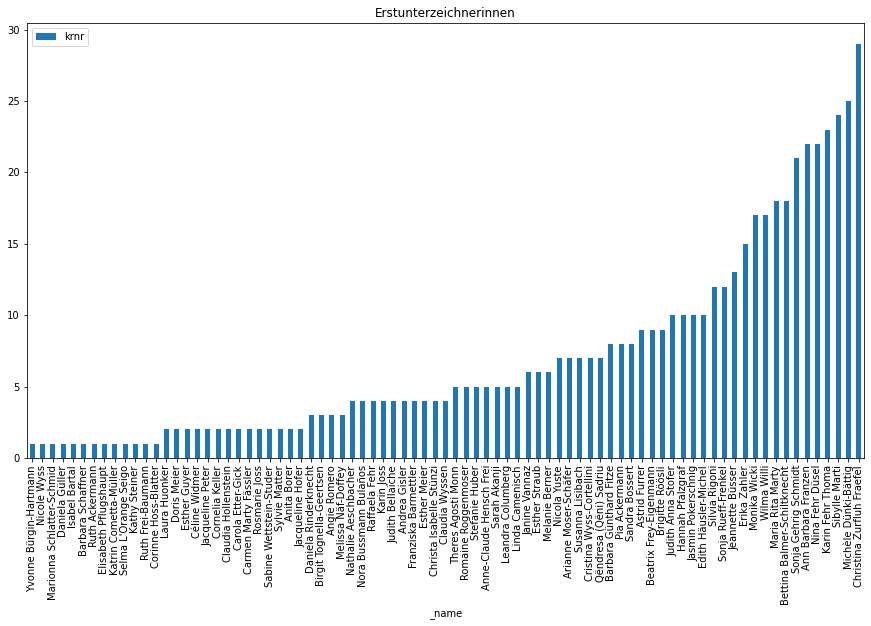

In [19]:
df.plot.bar(figsize=(15, 8), title='Erstunterzeichnerinnen')

In [20]:
print("Mean: %s" % df['krnr'].mean())
print("Median: %s" % df['krnr'].median())

Mean: 6.91358024691358
Median: 4.0


## What are men and women talking about? Let's find clusters!

In [21]:
clusters = {
    'kultur': ['kunsthaus', 'bührle', 'kultur', 'schauspielhaus', 'festival', 'kunst'],
    'corona': ['corona', 'covid', 'impf', 'home-office', 'home office', 'zertifikat', 'test', 'pcr', 'luftfilter', 'epidemi', 'pandemie', 'contact tracing', 'fruchtfolgefläche'],
    'landwirtschaft': ['landwirtschaft', 'tiere', 'gewächs', 'biodiversität', 'pestizide', 'landschaft'],
    'bildung': ['eth', 'bildung', 'lehr', 'schul', 'studien', 'zhdk', 'universität', 'gymi', 'beruf', 'forschung', 'studierende', 'professur', 'schüler'],
    'klima': ['energie', 'wasserstoff', 'biogas', 'co2', 'foodwaste', 'strom', 'Vegi'],
    'verkehr': ['parkierungsanlagen', 'flug', 'strasse', 'verkehr', 'fussgänger', 'tempo', 'mobilität', 'mobility', 'auto', 'weg', 'bahn', 'haltestelle', 'fahr',
                'tram', 'cargo', 'vbz', 'tunnel', 'halbstundentakt', 'schiene', 'durchmesserlinie', 'neat', 'bus', 'Zubringerlinie', 'westtangente'],
    'familien': ['kinder', 'eltern', 'jugend', 'partnerschaft', 'heirat', 'jugend', 'familien', 'alter'],
    'gesundheit': ['gesundheit', 'spital', 'ambulant', 'arzt', 'station', 'heim', 'pflege', 'usz', 'klinik', 'spitäl', 'demenz'],
    'gleichstellung': ['lgbt', 'weiblich', 'geschlechter'],
    'ausländer': ['ausländer', 'härtefallklausel', 'immigration'],
    'kriminalität': ['kriminal', 'gewalt', 'vollzug', 'polizei', 'sicherheit', 'gefängnis', 'verbrecher'],
    'digitalisierung': ['daten', 'informatik', 'e-id', 'software', 'digital', 'künstliche intelligenz', 'internet'],
    'behörden': ['behörden', 'verwaltung', 'kantonsrat'],
    'finanzen': ['finanzen', 'steuer', 'kredit', 'rechnung', 'zkb', 'budget', 'ausgaben'],
    'bauthemen': ['bau', 'sanier', 'immobilien', 'gebäude', 'liegenschaft'],
    'sozialthemen': ['arbeitslos', 'sozial', 'grundeinkommen', 'stellensuchende', 'asyl', 'integration'],
}

In [22]:
# Find Clusters based on dict above
df = df_raw[df_raw.erstunterzeichneristkantonsrat == True].copy()

def add_cluster(text):
    for cluster in clusters:
        for word in clusters[cluster]:
            if word.lower() in text.lower():
                return cluster

    return False

df['cluster'] = df['titel'].apply(add_cluster)

In [23]:
print("Anteil nicht geclusterter Geschäfte: %.1f%%" % (100 / len(df) * len(df[df.cluster == False])))

Anteil nicht geclusterter Geschäfte: 38.3%


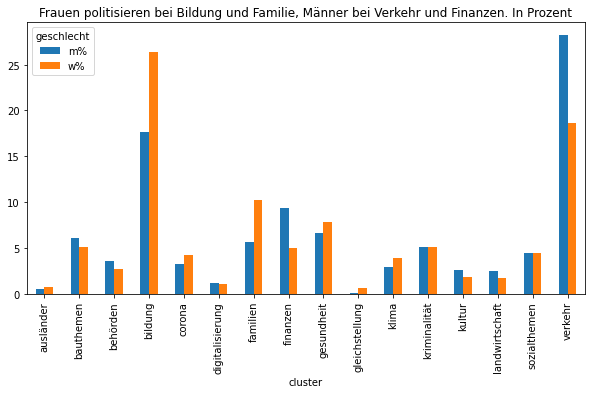

In [24]:
# Ready for Plot
df_clustered = df[df.cluster != False]

df_clustered = pd.pivot_table(df_clustered, index='cluster', columns='geschlecht', values='krnr', aggfunc='count')

df_clustered['m%'] = round(df_clustered['m'] * 100 / df_clustered['m'].sum(), 1)
df_clustered['w%'] = round(df_clustered['w'] * 100 / df_clustered['w'].sum(), 1)

df_clustered[['m%', 'w%']].plot.bar(figsize=(10, 5), title='Frauen politisieren bei Bildung und Familie, Männer bei Verkehr und Finanzen. In Prozent')
df_clustered.to_csv(csv_path / 'geschaefte_geclustert_nach_geschlecht.csv')

[csv Clusterdaten herunterladen](../export/csv_for_infographics/geschaefte_geclustert_nach_geschlecht.csv)

### Test: Find not detected words

In [25]:
from nltk.corpus import stopwords
from HanTa import HanoverTagger as ht
tagger = ht.HanoverTagger('morphmodel_ger.pgz')

stop_words = stopwords.words('german')

# Find most not clustered word
df_not = df[df.cluster == False]
words = []
for i, row in df_not.iterrows():

    for word in row['titel'].lower().split():
        if not(word in stop_words):
            words.append(tagger.analyze(word)[0])

df_word = pd.DataFrame({'word': words})
df_word['x'] = 1
df_word.groupby('word').agg({'x': 'count'}).sort_values('x', ascending=False).head(20)


,x
word,
Zürich,358
Kanton,327
--,86
zürcher,65
Massnahmen,54
Änderung,51
Kantonalen,46
neu,43
–,42
